# Water Simulation

This notebook contains a molecular dynamics simulation of water to investigate the influence of electrical and magnetic fields on polar water molecules.

The motion of all particles in the molecule are described by
$$m_i\frac{d^2\vec{r}_i}{dt^2} = \sum_{j \neq i}\vec{F}_{ij} + \vec{F}^{ext}_i$$. 
By summing over each particle $i$, we get
$$m_{tot}\frac{d^2\vec{r}_{cm}}{dt^2} = \sum_{i} \vec{F}^{ext}_i$$
with $m_{tot}= \sum_{i} m_i$ and the center-of-mass position $\vec{r}_{cm} = \frac{\sum_{i} m_i \vec{r}_i}{m_{tot}}$. The internal forces cancel out of the equation, because the magnitude of the force exhibited to particle $i$ by particle $j$ is the same as the force exhibited to particle $j$ by particle $i$, only the direction is different ($\vec{F}_{ij} = - \vec{F}_{ji}$).
$$m_i \vec{r}_i \times \frac{d^2\vec{r}_i}{dt^2} = \frac{d\vec{L}_i}{dt} = \vec{r}_i \times \sum_{j \neq i}\vec{F}_{ij} + \vec{r}_i \times \vec{F}^{ext}_i$$
where $\vec{L}_i = m_i \vec{r}_i \times \frac{d\vec{r}_i}{dt} =  m_i \vec{r}_i \times v_i$ is the angular momentum. If $(\vec{r}_i - \vec{r}_j ) \times \vec{F}_{ij} = 0$ is valid, the internal torques vanish and only the contribution from the external forces remains.
$$\frac{d\vec{L}_{tot}}{dt} = \sum_{i} \vec{r}_i \times \vec{F}^{ext}_i$$ with $\vec{L}_{tot} = \sum_{i}\vec{L}_{i}$.
The particles of the molecule are a rigid body with $v_{i} = \vec{\omega} \times \vec{r}_i$. The total angular momentum can be written as
$$\vec{L}_{tot} = \sum_{i} m_i \vec{r}_i \times v_i = \sum_{i} m_i \vec{r}_i \times \vec{\omega} \times \vec{r}_i = I \vec{\omega}$$
where $I$ is the moment of inertia tensor given by 
$I_{jk} = \sum_{i} m_{(i)} \left( r^2_{(i)} \delta_{jk} - r_{(i)j} r_{(i)k} \right)$.

In [175]:
import numpy as np
import scipy as sp
import scipy.constants as const
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tr

In [176]:
%matplotlib inline

The choice of the units for mass, length and time are the mass unit $u=1.660538921.10^{-27}kg$, the length unit $Angstrom= 10^{-10}m$ and the time unit $ps=10^{-12}s$.

In [177]:
PhysicalConstants = {
    "N" : const.atomic_mass*const.angstrom/const.pico**2,
    "speed of light" : const.speed_of_light/const.angstrom*const.pico,
    "V/m" : const.e/const.atomic_mass*const.pico**2/const.angstrom,
    "T" : const.e/const.atomic_mass*const.pico,
    "1/(4*pi*epsilon_0)" : 
    1/(4*np.pi*const.epsilon_0)*const.e**2/const.angstrom**2/(const.atomic_mass*const.angstrom/const.pico**2),
    "mu_0/(4*pi)" : 
    const.mu_0/(4*np.pi)*const.e**2/const.pico**2/(const.atomic_mass*const.angstrom/const.pico**2),    
    "48*epsilon_LJ" : 
    48.0*1.07602929792E-21/const.angstrom/(const.atomic_mass*const.angstrom/const.pico**2),
    "sigma_LJ" : 0.31668,
    "Boltzmann constant" : const.k/(const.atomic_mass*const.angstrom**2/const.pico**2)
}
PhysicalConstants

{'1/(4*pi*epsilon_0)': 138935.45755302778,
 '48*epsilon_LJ': 3110.399999999999,
 'Boltzmann constant': 0.8314459863587428,
 'N': 1.6605390400000001e-13,
 'T': 9.648533290731907e-05,
 'V/m': 9.648533290731907e-07,
 'mu_0/(4*pi)': 1.5458654463421154e-08,
 'sigma_LJ': 0.31668,
 'speed of light': 2997924.58}

The electromagnetic field generated by a molecule is a superposition of the electromagnetic fields of all its point charges.

The electrical field of a point charge at position $\vec{r}_q$ is

$$\vec{E}(\vec{r})=\frac{q}{4\pi\epsilon_0}\frac{(\vec{r}-\vec{r}_q)}{|\vec{r}-\vec{r}_q|^3}$$.

The magnetic field strength of a point charge with velocity $\vec{v_q}$ and position $\vec{r}_q$ is given by

$$\vec{B}(\vec{r})=\frac{\mu_0 q}{4\pi}\frac{\vec{v_q} \times (\vec{r}-\vec{r}_q)}{|\vec{r}-\vec{r}_q|^3}$$.

Retardation effects are neglected.

The Lennard-Jones potential is given by

$$V_{LJ}(r)=4\epsilon\left(\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right)$$

For water $\sigma=3.15365$  Angstrom and $\epsilon=0.648kJ/mol = 1.07603.10^{-21}J$.

The Lennard-Jones force is given by

$$F_{LJ}(r) = -\frac{\partial V_{LJ}(r)}{\partial r}=48\frac{\epsilon}{r}\left(\left(\frac{\sigma}{r}\right)^{12}-\frac{1}{2}\left(\frac{\sigma}{r}\right)^{6}\right)$$

The force is zero at $r=2^{1/6}\sigma=3.17$ Angstrom.

**Building the molecule from a point mass and charge distribution**

A generic molecule builder class, which allows the user to build a molecule by adding masses and charges using the *addPointMass* and *addPointCharge* methods. After the *create* method has been called, the structure is immutable and a proper coordinate system is chosen with the origin in the center of mass and the axis directions in such a way that the moment of inertia tensor 
is diagonal.

In [178]:
class MoleculeBuilder:
    "A generic class for the construction of a molecule structure with a given mass and charge distribution"
    
    class Mass:
        
        def __init__(self,m,pos,name=''):
            self.m = m
            self.pos = np.asarray(pos)
            self.name = name

    class Charge:
        
        def __init__(self,q,pos):
            self.q = q
            self.pos = np.asarray(pos)
            
    def __init__(self):
        self.__masses = []
        self.__charges = []

    def getProperties(self):
        """
        M .... total mass
        m .... list of particle masses
        q .... list of particle charges
        rm ... position matrix
        rq ... charge matrix
        mi ... inertia tensor (eigen values)
        nm ... number of point masses
        nq ... number of point charges
        names ... particle names
        """        
        return {'M':np.sum(self.__m),
                'm':self.__m,
                'q':self.__q,
                'rm':self.__rm, 
                'rq':self.__rq,
                'mi':self.__mi,
                'nm':self.__nm,
                'nq':self.__nq,
                'names':self.__names}       
        
    def addPointMass(self,m,pos,name=''):
        "Add a mass m to a certain position in the molecule"
        self.__masses.append(MoleculeBuilder.Mass(m,pos,name))

    def addPointCharge(self,q,pos):
        "Add a charge q to a certain position in the molecule"
        self.__charges.append(MoleculeBuilder.Charge(q,pos))
        
    def create(self):
        "Creates the molecule's internal structure"
        self.__nm = len(self.__masses)
        self.__nq = len(self.__charges)
        # mass matrix
        self.__m = []
        # charge matrix
        self.__q = []
        # mass position matrix
        self.__rm = []
        # charge position matrix
        self.__rq = []
        # names
        self.__names = []
        # center of mass is the origin of the molecule's fixed body system
        cm = self.getCenterOfMass()
        for i in range(self.__nm):
            self.__m.append(self.__masses[i].m)
            self.__rm.append(self.__masses[i].pos - cm)
            self.__names.append(self.__masses[i].name)
        for i in range(self.__nq):
            self.__q.append(self.__charges[i].q)
            self.__rq.append(self.__charges[i].pos - cm)
        self.__m = np.asarray(self.__m)
        self.__q = np.asarray(self.__q)
        self.__rm = np.transpose(np.asarray(self.__rm))
        self.__rq = np.transpose(np.asarray(self.__rq))
        # calculate the moment of inertia tensor
        self.__mi = np.zeros([3,3])
        for i in range(self.__nm):
            r = self.__rm[:,i]
            r2 = np.sum(r*r)
            m = self.__m[i]
            self.__mi = self.__mi + m * (r2 * np.eye(3) - np.outer(r,r))
        # choose the coordinate system, which diagonalizes the tensor
        e,v = np.linalg.eig(self.__mi)
        # apply coordinate transformation to mass and charge positions
        self.__rm = np.dot(v,self.__rm)
        self.__rq = np.dot(v,self.__rq)
        # the eigenvalues may be not in the right order!
        self.__mi = e

        
    def getCenterOfMass(self):
        "Calculates the center of mass position"
        p = np.zeros([3])
        m = 0.0
        for mass in self.__masses:
            p = p + mass.m * mass.pos
            m = m + mass.m
        return p/m
 

In [179]:
class Buffer:
    "A generic container with a fixed size"

    def __init__(self,size=10):
        self.container = list()
        self.size = size
        
    def add(self,elem):
        if len(self.container) >= self.size:
            self.container.pop(0)
        self.container.append(elem)

    def get(self,index):
        "Index 0 is the last entry x(t), index -1 is x(t-dt/2), index -2 is x(t-dt) and so on"
        assert(index<=0)
        i = len(self.container) - 1 + index
        if i < 0:
            i = 0
        return self.container[i]

    def set(self,index,value):
        "Index 0 is the last entry x(t), index -1 is the previous entry x(t-dt/2) and so on"
        assert(index<=0)
        i = len(self.container) - 1 + index
        if i < 0:
            i = 0
        self.container[i] = value
        return self.container[i]

    def isFull(self):
        return len(self.container) >= self.size
        
    def show(self):
        "Shows the buffer content as [x(t),x(t-dt/2),x(t-dt)...]"
        s = "["
        for i in range(len(self.container)):
            s = s + " " + str(self.get(-i))
        print s + " ]\n"

In [180]:
class Molecule:
    "A generic class for a molecule with six translational and six rotational degrees of freedom"

    eps = 0.001
    eps2 = eps * eps
    properties = {}
            
    def __init__(self,r0,v0,q0,w0,name,sys=None):
        "Initializes the state vector (r,v,q,w) with intial values (r0,v0,q0,w0) at time t=t0"
        self.name = name
        self.sys = sys
        # center of mass position and velocity
        bufferSize = 3
        self.r = Buffer(size = bufferSize)
        self.r.add(np.asarray(r0).reshape([3]))
        self.v = Buffer(size = bufferSize)
        self.v.add(np.asarray(v0).reshape([3]))
        # quaternion (q0,q1,q2,q3)
        self.q = Buffer(size = bufferSize)
        self.q.add(np.asarray(q0).reshape([4]))
        self.w = Buffer(size = bufferSize)
        self.w.add(np.asarray(w0).reshape([3]))
        # rotation matrix
        self.R = Molecule.getRotationMatrix(self.q.get(0))
        # angular momentum
        self.L = Buffer(size = bufferSize)
        self.L.add(self.getAngularMomentum(self.w.get(0)))
        # accelerations
        self.a = Buffer(size = bufferSize)
        # self.a.add((np.zeros(3),np.zeros(3)))
        # the cell the molecule is located as if the periodic boundary conditions were not applied
        self.cell = np.zeros([3])
        
    @staticmethod
    def getRotationMatrix(q):
        return tr.quaternion_matrix(q)[0:3,0:3]
        
    def getAngularMomentum(self,w):
        i_body = np.diag(self.getProperty('mi'))
        i = np.dot(self.R,np.dot(i_body,self.R.T))
        return np.dot(i,w)
    
    def q_dot(self):
        "Calculates the time derivative of the quaternion"
        wq = np.zeros(4)
        wq[1:4] = self.w.get(0)
        q_dot = tr.quaternion_multiply(wq,self.q.get(0)) / 2.0
        return q_dot

    def normalize(self, q):
        "Normalizes the quaternion"
        q2 = np.dot(q.T,q)
        if q2 > 0:
            return q/np.sqrt(q2)
        return q
    
    def repl(self, m, nr=1, nc=1):
        "Replicates matrix m nr times in row direction and nc times in column direction"
        mr,mc = m.shape
        M = np.zeros([mr*nr,mc*nc])
        for i in range(nr):
            for j in range(nc):
                M[i*mr:(i+1)*mr,j*mc:(j+1)*mc] = m
        return M
    
    def concat(self, v, nc=1):
        "Concatenates vector nc times in column direction"
        vr = v.size
        M = np.zeros([vr,nc])
        for i in range(nc):
            M[:,i] = v
        return M
    
    def getProperty(self, prop):
        return Molecule.properties[self.name][prop]
    
    def getMassPositions(self):
        "Calculates the absolute positions of the mass distribution in the molecule"
        r = np.dot(self.R, self.getProperty('rm'))
        return self.concat(self.r.get(0), self.getProperty('nm')) + r

    def getMassVelocities(self):
        "Calculates the absolute velocities of the mass distribution in the molecule"
        v = np.cross(self.w.get(0),np.transpose(np.dot(self.R, self.getProperty('rm'))))
        return self.concat(self.v.get(0), self.getProperty('nm')) + v.T
    
    def getChargePositions(self):
        "Calculates the absolute positions of the charge distribution in the molecule"
        r = np.dot(self.R, self.getProperty('rq'))
        return self.concat(self.r.get(0), self.getProperty('nq')) + r

    def getChargeVelocities(self):
        "Calculates the absolute velocities of the charge distribution in the molecule"
        v = np.cross(self.w.get(0),np.transpose(np.dot(self.R, self.getProperty('rq'))))
        return self.concat(self.v.get(0), self.getProperty('nq')) + v.T
    
    def getDistance(self,molecule,cell):
        "Calculates the center of mass distance to another molecule"
        dist = self.r.get(0) - molecule.r.get(0) - cell
        return np.sqrt(np.sum(dist*dist))
    
    def getElectroMagneticMolecularForce(self, x, v, cell):
        "Calculates the force created by the electrical and magnetic fields of the charges in the molecule"
        rx = np.asarray(x) - cell
        E = np.zeros([3])
        B = np.zeros([3])
        rq = self.getChargePositions()
        vq = self.getChargeVelocities()
        q = self.getProperty('q')
        for i in range(self.getProperty('nq')):
            dx = rx - rq[:,i]
            r = np.sqrt(np.sum(dx*dx))
            if r < Molecule.eps:
                print "getElectroMagneticMolecularForce: particles are too close " + str(dx)
            e = q[i]/r**3*dx
            E = E + e
            B = B + np.cross(vq[:,i],e)
        F = PhysicalConstants["1/(4*pi*epsilon_0)"] * E
        F = F + PhysicalConstants["mu_0/(4*pi)"] * np.cross(v,B)
        return F

    def getExternalElectroMagneticForce(self,x,v):
        "Returns the external time-dependent force on a unit charge"
        E = self.sys.getElectricField(x) * PhysicalConstants["V/m"]
        B = self.sys.getMagneticField(x) * PhysicalConstants["T"]
        F = E + np.cross(v,B)
        return F
        
    def getLennardJonesForce(self,x,cell):
        "Returns the Lennard Jones force"
        F = np.zeros(3)
        rx = np.asarray(x)
        dx = rx - self.r.get(0) - cell
        r2 = np.sum(dx*dx)
        if r2 < Molecule.eps2:
            print "getLennardJonesForce: particles are too close " + str(dx)
        sigma = PhysicalConstants["sigma_LJ"]
        f = (sigma*sigma/r2)**3
        F = PhysicalConstants["48*epsilon_LJ"] * f * (f - 0.5) / r2 * dx
        return F
    
    def getTotalEnergy(self, method = 1):
        "Calculates the sum of kinetic and rotational energy of a molecule"
        if method == 1:
            v = self.v.get(0)
            m = self.getProperty('M')
            w = self.w.get(0)
            E = np.sum(m*v*v + w*self.getAngularMomentum(w)) / 2.0
        else:
            v = self.getMassVelocities()
            m = self.getProperty('m')
            E = np.sum(np.dot(v*v,m)) / 2.0
        return E
    
    def getForceAndTorque(self):
        "Calculates the forces and torques acting on the molecule"
        F = np.zeros(3)
        T = np.zeros(3)

        # charge distribution
        rq = self.getChargePositions()
        vq = self.getChargeVelocities()
        q = self.getProperty('q')
        nq = self.getProperty('nq')
        rr = self.r.get(0)

        for cell in self.sys.cells:
            for molecule in self.sys.molecules:
                if molecule == self:
                    continue
                dist = self.getDistance(molecule,cell)
                if dist < self.getProperty('cutoffs')['Coulombic']:
                    # pair-wise electromagnetic interaction
                    # get electromagnetic forces from the other molecules on each constituent
                    for i in range(nq):
                        r = rq[:,i]
                        v = vq[:,i]
                        fi = q[i] * molecule.getElectroMagneticMolecularForce(r,v,cell)
                        F = F + fi
                        r = r - rr
                        T = T + np.cross(r,fi)

                # Lennard-Jones potential     
                # get Lennard Jones force from the other molecules
                if dist < self.getProperty('cutoffs')['LennardJones']:
                    F = F + molecule.getLennardJonesForce(rr,cell)
                # no torque present

        # get forces from external electromagnetic fields
        for i in range(nq):
            r = rq[:,i]
            v = vq[:,i]
            fi = q[i] * self.getExternalElectroMagneticForce(r,v)
            F = F + fi
            r = r - rr
            T = T + np.cross(r,fi)
        
        return (F,T)

    def updateHalfStep(self, dt):
        "Update state vector by t+dt/2"   
        
        (a,aa) = self.a.get(0)
        m_body = self.getProperty('M')
        i_body = self.getProperty('mi')
        delta_t = dt/2.0
        
        if self.a.isFull():

            # update r and q
            self.r.add(2.0*self.r.get(0) - self.r.get(-1) + delta_t * delta_t * a/m_body)
            self.v.add(self.v.get(-1) + a/m_body * dt)       

            # update q and L
            self.q.add(self.normalize(self.q.get(-1) + dt * self.q_dot()))
            self.L.add(self.L.get(-1) + aa * dt)

        else:
        
            # update r and q
            self.r.add(self.r.get(0) + delta_t * self.v.get(0))
            self.v.add(self.v.get(0) + a/m_body * delta_t)
            
            # update q and L
            self.q.add(self.normalize(self.q.get(0) + delta_t * self.q_dot()))
            self.L.add(self.L.get(0) + aa * delta_t)


            
        # rotation matrix
        self.R = Molecule.getRotationMatrix(self.q.get(0))
        i_inv = np.dot(self.R,np.dot(np.diag(1.0/i_body),self.R.T))
        self.w.add(np.dot(i_inv,self.L.get(0)))

    def updateFullStep(self, dt):
        "Update state vector by t+dt"   
        
        (a,aa) = self.a.get(0)
        m_body = self.getProperty('M')
        i_body = self.getProperty('mi')
        delta_t = dt/2.0
        
        if self.a.isFull():

            # update r and q
            self.r.add(2.0*self.r.get(0) - self.r.get(-1) + delta_t * delta_t * a/m_body)
            self.v.add(self.v.get(-1) + a/m_body * dt)       

            # update q and L
            self.q.add(self.normalize(self.q.get(-1) + dt * self.q_dot()))
            self.L.add(self.L.get(-1) + aa * dt)

        else:
        
            # update r and q
            self.r.add(self.r.get(0) + delta_t * self.v.get(0))
            self.v.add(self.v.get(0) + a/m_body * delta_t)

            # update q and L
            self.q.add(self.normalize(self.q.get(0) + delta_t * self.q_dot()))
            self.L.add(self.L.get(0) + aa * delta_t)

        # rotation matrix
        self.R = Molecule.getRotationMatrix(self.q.get(0))
        i_inv = np.dot(self.R,np.dot(np.diag(1.0/i_body),self.R.T))
        self.w.add(np.dot(i_inv,self.L.get(0)))


The used integrator is an extension of the Velocity Verlet algorithm, where the position update is given by

$$\vec{x}(t+\delta t)=2\vec{x}(t)-\vec{x}(t-\delta t) + \vec{a}(t)\delta t^2$$. Based on these new positions, the force $\vec{F}(t+\delta t) = \vec{F}(\vec{x}(t+\delta t))$ and the acceleration $\vec{a}(t+\delta t) = \vec{F}(t+\delta t)/m$ is calculated. The velocity update is given by

$$\vec{v}(t+\delta t)=\vec{v}(t) + \frac{\vec{a}(t) + \vec{a}(t+\delta t)}{2}\delta t$$

If the forces are velocity-dependent, the Velocity Verlet algorithm cannot be applied directly. A modified version of Velocity Verlet algorithm divides the update into two half steps. The position update is given by

$$\vec{x}(t+\delta t/2)=2\vec{x}(t)-\vec{x}(t-\delta t/2)+\vec{a}(t)\left(\frac{\delta t}{2}\right)^2$$

while the velocity update is given by

$$\vec{v}(t+\delta t/2)=\vec{v}(t-\delta t/2) + \vec{a}(t)\delta t$$

Calculate the force $\vec{F}(t+\delta t/2) = \vec{F}(\vec{x}(t+\delta t/2),\vec{v}(t+\delta t/2))$ and $\vec{a}(t+\delta t/2) = \vec{F}(t+\delta t/2)/m$. The position update is given by

$$\vec{x}(t+\delta t)=2\vec{x}(t)-\vec{x}(t-\delta t)+\vec{a}(t)\left(\delta t\right)^2$$

The velocity update is given by

$$\vec{v}(t+\delta t)=\vec{v}(t) + \vec{a}(t+\delta t/2)\delta t$$

Calculate the force $\vec{F}(t+\delta t) = \vec{F}(\vec{x}(t+\delta t),\vec{v}(t+\delta t))$ and $\vec{a}(t+\delta t) = \vec{F}(t+\delta t)/m$.

Two force evaluations are necessary in each timestep.

A water molecule inherits from the base class Molecule and creates all the properties, which are specific to $H_2O$. All molecules of a certain type share the same unique name and access their properties through this key. The water molecule is based on the TIP4P model.

In [181]:
class H2O(Molecule):
        
    def __init__(self,r0=np.zeros(3),v0=np.zeros(3),q0=np.zeros(4),w0=np.zeros(3),sys=None):
        "Creates instances of water molecules with the supplied degrees of freedom"
        self.sys = sys
        # unique key to identify water molecule
        key = 'H2O'
        if not key in Molecule.properties:
            # build a H2O molecule based on TIP4P water model
            builder = MoleculeBuilder()
            # mass of the oxygen atom in units of const.atomic_mass
            m_oxygen = 15.9994
            # m_oxygen = 16
            # mass of the hydrogen atom in units of const.atomic_mass
            m_hydrogen = 1.007825
            # m_hydrogen = 1
            # angle spanned by the two hydrogen atoms in deg
            angle_OHH = 104.52
            # distance between oxygen and hydrogen atom in const.angstrom
            r_OH = 0.9572
            # distance between oxygen and center of mass in const.angstrom
            r_OM = 0.15
            # positive charge at the hydrogen atoms in units of const.e
            q_pos = +0.52
            # negative charge at the center of mass in units of const.e
            q_neg = -2*q_pos
            # time scale is fs
            
            # the coordinate system used is that the atoms lies in the x-y plane
            # with OM on the y-axis.

            # add masses
            deg2rad = np.pi/180.0
            s = np.sin(angle_OHH/2.0*deg2rad)
            c = np.cos(angle_OHH/2.0*deg2rad)
            r_oxygen = [0,0,0]
            builder.addPointMass(m_oxygen,r_oxygen,'O')
            r_hydrogen_left = np.array([-s,-c,0])*r_OH
            r_hydrogen_right = np.array([s,-c,0])*r_OH
            builder.addPointMass(m_hydrogen,r_hydrogen_left,'H')
            builder.addPointMass(m_hydrogen,r_hydrogen_right,'H')
            
            # add charges
            # r_cm = builder.getCenterOfMass()
            r_negative_charge = [0,-r_OM,0]
            builder.addPointCharge(q_neg,r_negative_charge)
            builder.addPointCharge(q_pos,r_hydrogen_left)
            builder.addPointCharge(q_pos,r_hydrogen_right)
            builder.create()
            Molecule.properties[key] = builder.getProperties()
            
            # add cutoffs
            Molecule.properties[key]['cutoffs'] = {'Coulombic' : 8.5, 'LennardJones' : np.inf}
        Molecule.__init__(self,r0,v0,q0,w0,key,sys)


The simulation is performed with $N$ water molecules at $T=300K$ in a cubic box (primary cell) with density of $1g/cm^3$. The primary cell is surrounded by 6 image cells, which contain the same particles as the primary cell. The particles in these cells have the same trajectories as the particles in the reference cell. They apply forces to the particles in the primary cell, but their motion is not affected by the other particles.

If a particle moves out of the primary cell, a corresponding particle from an image cell moves into the primary cell. Therefore the number of particles in the primary cell is constant over time.

The particles in the reference cell are created at random grid positions, so that they are uniformly distributed over the whole space of the box. If the positions would be chosen totally random, it could be that 2 particles are so close together that the forces between them are big and the integration becomes numerically instable. It is therefore necessary to start the simulation with a configuration in thermal equilibrium.

The velocities are chosen randomly from a normal distribution with mean $0$ and $\sigma=\sqrt{\frac{kT}{m}}$, where $m$ is the total molecule mass.

In [182]:
class System:
    
    def __init__(self, t0 = 0.0):
        # only one type of molecules is supported
        self.molecules = []
        # system time
        self.t = t0
        # add primary cell
        self.cells = [np.zeros([3])]        
        
    def add(self,molecule):
         self.molecules.append(molecule)
        
    def getElectricField(self,x):
        "The electric field of the system in V/m"
        E = np.zeros([3])
        return E
    
    def getMagneticField(self,x):
        "The magnetic field of the system in T"
        B = np.zeros([3])
        return B
    
    def getRandomPositions(self,N,L):
        "Divides the box of size L x L x L in smaller cells and assigns randomly each particle to a cell"
        n = max(np.floor(N**(1.0/3.0)),1)
        l = float(L)/n
        rndpos = []
        i = 0
        while i < N:
            x = np.floor(np.random.random_sample(3)*(n+1))
            different = True
            for pos in rndpos:
                if np.all(pos == x):
                    different = False
                    break
            if different:
                rndpos.append(x)
                i = i + 1
        return np.array(rndpos)*l/2.0 + np.ones([N,3])*l/4.0
    
    def getMeanEnergy(self, method = 1):
        E = 0
        N = len(self.molecules)
        for molecule in self.molecules:
            E = E + molecule.getTotalEnergy(method)
        return E / N 
   
    def applyPeriodicBoundaryConditions(self,box):
        for i in range(len(box)):
            L = box[i]
            for molecule in self.molecules:
                r = molecule.r.get(0)
                if r[i] > L:
                    molecule.cell[i] = molecule.cell[i] + L
                    for n in range(molecule.r.size):
                        rr = molecule.r.get(-n)
                        rr[i] = rr[i] - L
                        
                if r[i] < 0:
                    molecule.cell[i] = molecule.cell[i] - L
                    for n in range(molecule.r.size):
                        rr = molecule.r.get(-n)
                        rr[i] = rr[i] + L

In [183]:
class Thermostat:
    "The Thermostat base class implements a Berendsen thermostat"
    
    def __init__(self,sys,T = 300.0,dof = 6):
        self.sys = sys
        self.thermal_energy = dof * PhysicalConstants["Boltzmann constant"] * T / 2.0
        
    def applyCorrections(self, alpha = 0.001):
        E = self.sys.getMeanEnergy()
        lam = 1.0 + alpha * (self.thermal_energy/E - 1.0)
        if lam < 0:
            print "Thermostat: velocity scale factor < 0"
            return
        lam = np.sqrt(lam)
        for molecule in self.sys.molecules:
            for n in range(molecule.v.size):
                v = molecule.v.get(-n)
                v = lam * v
                molecule.v.set(-n,v)
#            for n in range(molecule.w.size):
#                w = molecule.w.get(-n)
#                w = lam * w
#                molecule.w.set(-n,w)
            for n in range(molecule.L.size):
                L = molecule.L.get(-n)
                L = lam * L
                molecule.L.set(-n,L)


In [184]:
class WaterSimulator(System):
    
    def __init__(self,N=100,T=300.0):
        "Creates a system of N water molecules at temperature T (in K)"
        System.__init__(self) 
        # initialize H2O properties
        self.molecule = H2O()
        # density of water 1000kg/m^3
        density = 1000.0
        # total mass of the molecule in kg
        m_u = self.molecule.getProperty('M')
        print 'Water molecule has mass ' + str(m_u) + 'u'
        # convert to kg
        m = m_u*const.atomic_mass
        # V ... volume of the system in m^3
        V = N*m/density
        # L ... length of the system in Angstrom
        self.L = V**(1.0/3.0)/const.angstrom
        print 'The box has side length L = ' + str(self.L) + ' A'
        # conversion of temperature to energy
        thermal_energy = PhysicalConstants["Boltzmann constant"]*T
        print "Thermal energy per degree of freedom is k*T/2 = " + str(thermal_energy/2.0) + "u(A/ps)^2 at T=" + str(T) + "K"
        # molecule velocity
        v = np.sqrt(thermal_energy/(m_u))
        print "Velocity = " + str(v) + "A/ps"
        # molecule angular velocity
        i_body_inv = np.diag(1.0/self.molecule.getProperty('mi'))
        w = np.sqrt(thermal_energy/self.molecule.getProperty('mi'))
        print "Angular velocity = " + str(w) + " rad/ps"
        # add image cells
        self.cells.append(np.array([self.L,0,0]))
        self.cells.append(np.array([-self.L,0,0]))
        self.cells.append(np.array([0,self.L,0]))
        self.cells.append(np.array([0,-self.L,0]))
        self.cells.append(np.array([0,0,self.L]))
        self.cells.append(np.array([0,0,-self.L]))
        self.thermostat = Thermostat(self,T)
        
        # generate a system of N water molecules
        r0 = self.getRandomPositions(N,self.L)
        # r0 = np.random.random_sample(3*N).reshape([3,N])*self.L
        for i in range(N):
            # r0 = np.random.random_sample(3)*self.L
            v0 = np.random.normal(0, v, 3)
            q0 = tr.random_quaternion()
            R0 = Molecule.getRotationMatrix(q0)
            cov = thermal_energy * np.dot(R0,np.dot(i_body_inv,R0.T))
            w0 = np.random.multivariate_normal([0,0,0], cov, 1)
            #w0 = np.zeros(3)
            #for k in range(3):
            #    w0[k] = np.random.normal(0, w[k], 1)
            #r0 = np.zeros(3)
            #v0 = np.zeros(3)
            #q0 = tr.quaternion_about_axis(30.0*np.pi/180.0, [1, 0, 0])
            #w0 = np.zeros(3)
            System.add(self,H2O(r0[i,:],v0,q0,w0,self))
        print "Mean energy = " + str(self.getMeanEnergy(method = 1))
        
    def getElectricField(self,x):
        "The electric field of the system"
        if self.t < 0:
            E = np.zeros([3])
        else:
            E = np.array([0.0,0.0,0.0])
        return E

    def getMagneticField(self,x):
        "The magnetic field of the system in T"
        if self.t < 0:
            B = np.zeros([3])
        else:
            B = np.array([0.0,0.0,0.0])
        return B

    def save(self, f):
        "Saves all atoms of the current timestep"
        n = len(self.molecules)
        nm = self.molecule.getProperty('nm')
        names = self.molecule.getProperty('names')
        f.write(str(n*nm) + '\n')
        f.write('Coordinates in Angstrom at t = ' + str(self.t) + ' ps\n')
        for molecule in self.molecules:
            pos = molecule.getMassPositions()
            for i in range(nm):
                f.write(names[i] + ' ' + str(pos[0,i]) + ' ' + str(pos[1,i]) + ' ' + str(pos[2,i]) + '\n')            

    def run(self,timeStart=0.0,timeSteps=1000,timeResolution=1.0,filename='trajectory.xyz',r=None):
        "Runs the simulation"

        L = self.L
        f = open(filename, mode='w')
        f.close()
        f = open(filename, mode='a')
        self.t = timeStart
        
        print "Simulation started ... "
        for steps in range(timeSteps): 
        
            # calculate all accelerations and torques from x(t),v(t)
            for molecule in self.molecules:
                molecule.a.add(molecule.getForceAndTorque())
                # print molecule.a.get(0)

            # update state vector by x(t+dt/2),v(t+dt/2)
            for molecule in self.molecules:
                molecule.updateHalfStep(dt = timeResolution)

            # calculate all accelerations and torques from x(t+dt/2),v(t+dt/2)
            for molecule in self.molecules:
                molecule.a.add(molecule.getForceAndTorque())
                # print molecule.a.get(0)

            # update state vector by x(t+dt),v(t+dt)
            for molecule in self.molecules:
                molecule.updateFullStep(dt = timeResolution)

            # apply boundary conditions
            System.applyPeriodicBoundaryConditions(self,[L,L,L])
            
            # apply corrections from thermostat
            self.thermostat.applyCorrections(alpha=0.1)
            
            # unwrap positions
            l = []
            for molecule in self.molecules:
                l.append(molecule.r.get(0) + molecule.cell)
            r.append(l)
        
            self.t = self.t + timeResolution
            self.save(f)
    
        f.close()
        print "Mean energy (end of simulation) = " + str(self.getMeanEnergy(method=1))
        
        # print the mean velocity for each molecule
        # for i in range(len(self.molecules)):
        #    print "v[m/s] = " + str(v[:,i]*100/timeSteps)
        print "done"

In [185]:
simulator = WaterSimulator(N=100)
data = []
%time simulator.run(timeSteps=5000,timeResolution=0.0002,r=data)

Water molecule has mass 18.01505u
The box has side length L = 4.4771530311 A
Thermal energy per degree of freedom is k*T/2 = 124.716897954u(A/ps)^2 at T=300.0K
Velocity = 3.72100207358A/ps
Angular velocity = [ 20.14770641  14.69612054  11.87314945] rad/ps
Mean energy = 820.960090471
Simulation started ... 
Mean energy (end of simulation) = 1454.31868762
done
Wall time: 1min 13s


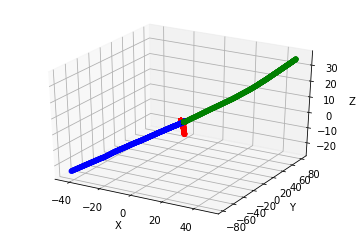

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

r = np.array(data)
[k,l,m] = r.shape
color = ['r','b','g']
for m in range(l):
    ax.scatter(r[:,m,0], r[:,m,1], r[:,m,2], c=color[m % 3])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [187]:
np.random.multivariate_normal([0,0,0], np.eye(3), 1)

array([[-1.60904429,  0.13947538, -2.10299988]])